Use the initial condition prescribed in example here: http://databookuw.com/databook.pdf#page=93

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [30]:
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
# plt.rc("text", usetex=True)

In [31]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
x_all = np.linspace(0, L, n+2)  # Full spatial grid.
x = x_all[1:-1]                 # Interior spatial grid (where q is unknown).
dx = x[1] - x[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
K = T*10**3 + 1                 # Temporal grid size.
t = np.linspace(0, T, K)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size δx = {dx}")
print(f"Temporal step size δt = {dt}")

Spatial step size δx = 0.0078125
Temporal step size δt = 0.001


In [32]:
x_all.shape

(129,)

In [33]:
# Construct the full-order state matrix A.
dx2inv = 1 / dx**2
diags = np.array([1, -2, 1]) * dx2inv
A = sparse.diags(diags, [-1, 0, 1], (n, n))

In [34]:
# Construct the full-order input matrix B.
B = np.zeros_like(x)
B[0], B[-1] = dx2inv, dx2inv
B.shape # doubt how is B approximating the original PDE correctly????

(127,)

In [35]:
alpha = 100

wave_lb = np.floor((L/2 - L/8)/dx).astype(int)
wave_ub = np.floor((L/2 + L/8)/dx).astype(int)

print("Index for Wave Begin and End is {}, {}".format(wave_lb, wave_ub))

q0 = np.zeros(x.shape)
q0[wave_lb:wave_ub] = 1

Index for Wave Begin and End is 48, 80


In [36]:
def implicit_euler(t, q0, A):
    """Solve the system

        dq / dt = Aq(t),    q(0) = q0,

    over a uniform time domain via the implicit Euler method.

    Parameters
    ----------
    t : (k,) ndarray
        Uniform time array over which to solve the ODE.
    q0 : (n,) ndarray
        Initial condition.
    A : (n, n) ndarray
        State matrix.

    Returns
    -------
    q : (n, k) ndarray
        Solution to the ODE at time t; that is, q[:,j] is the
        computed solution corresponding to time t[j].
    """
    # Check and store dimensions.
    k = len(t)
    n = len(q0)

    assert A.shape == (n, n)

    I = np.eye(n)

    # Check that the time step is uniform.
    dt = t[1] - t[0]
    assert np.allclose(np.diff(t), dt)

    # Factor I - dt*A for quick solving at each time step.
    factored = la.lu_factor(I - dt*A)

    # Solve the problem by stepping in time.
    q = np.empty((n, k))
    q[:,0] = q0.copy()
    for j in range(1, k):
        q[:, j] = la.lu_solve(factored, q[:, j-1])

    return q

In [37]:
Q_all = implicit_euler(t, q0, A)
Q_all.shape

(127, 1001)

In [38]:
# Retain only the first k snapshots/inputs for training the ROM.
k = 100                         # Number of training snapshots.
t_train = t[:k]                 # Temporal domain for training snapshots.
Q = Q_all[:, :k]                # Observed snapshots.

In [39]:
# Estimate time derivatives (dq/dt) for each training snapshot.
Qdot_train = (Q[:, 1:] - Q[:, :-1]) / dt
Q_train = Q[:, 1:]              # Training snapshots.

print(f"shape of Q_train:\t{Q_train.shape}")
print(f"shape of Qdot_train:\t{Qdot_train.shape}")

shape of Q_train:	(127, 99)
shape of Qdot_train:	(127, 99)


In [40]:
def plot_heat_data(Z, title, ax=None):
    """Visualize temperature data in space and time."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 10, 20, 40, 80, 160, 320, 640]
    sample_columns = [0] + [2**d for d in range(10)]
    color = iter(plt.cm.viridis_r(np.linspace(.05, 1, len(sample_columns))))
    while sample_columns[-1] > Z.shape[1]:
        sample_columns.pop()
    leftBC, rightBC = [0], [0]
    for j in sample_columns:
        q_all = np.concatenate([leftBC, Z[:,j], rightBC])
        ax.plot(x_all, q_all, color=next(color), label=fr"$q(x,t_{{{j}}})$")

    ax.set_xlim(x_all[0], x_all[-1])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$q(x,t)$")
    ax.legend(loc=(1.05, .05))
    ax.set_title(title)

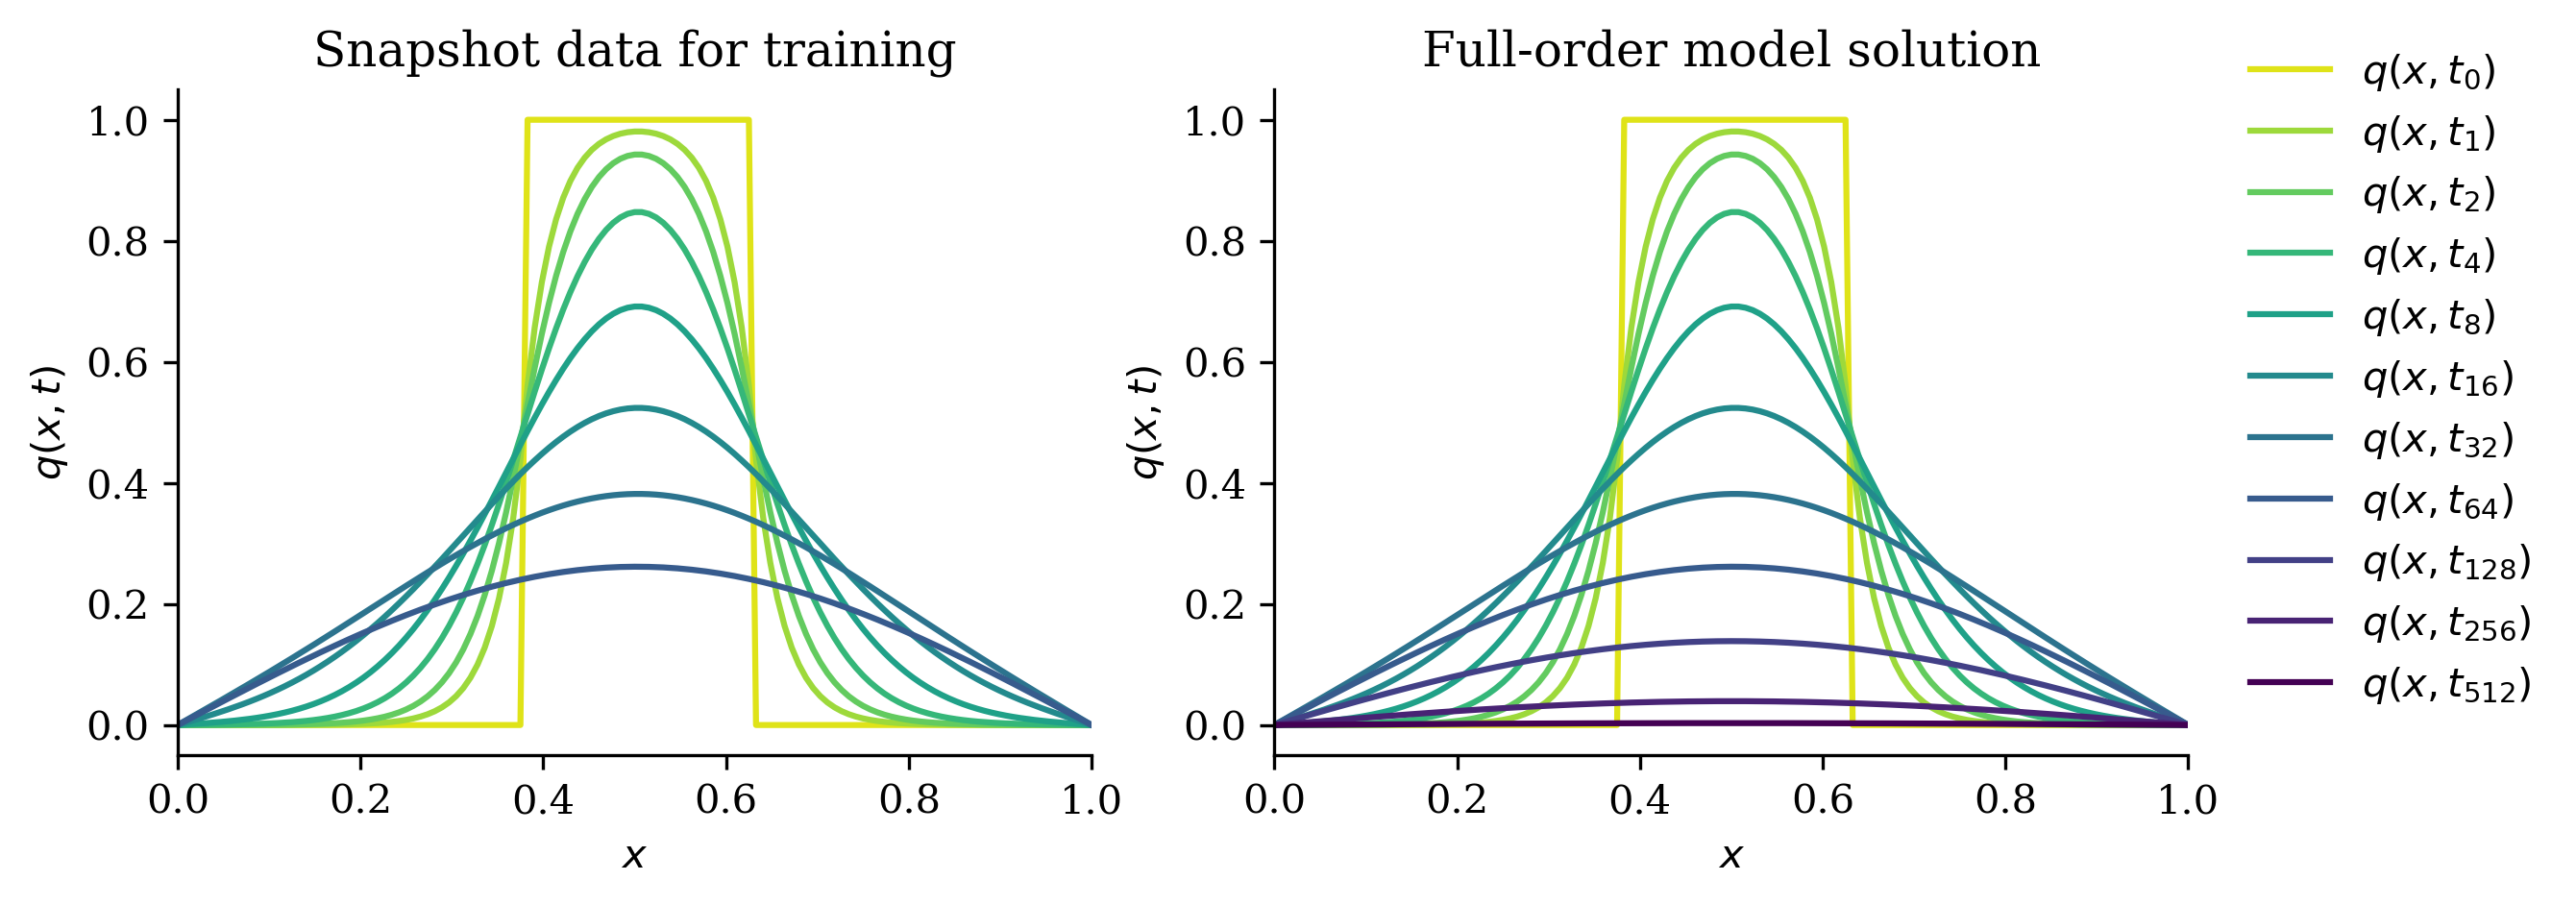

In [41]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q, "Snapshot data for training", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()

PODBasis
Full-order dimension    n = 127
Reduced-order dimension r = 8


(0.0, 25.0)

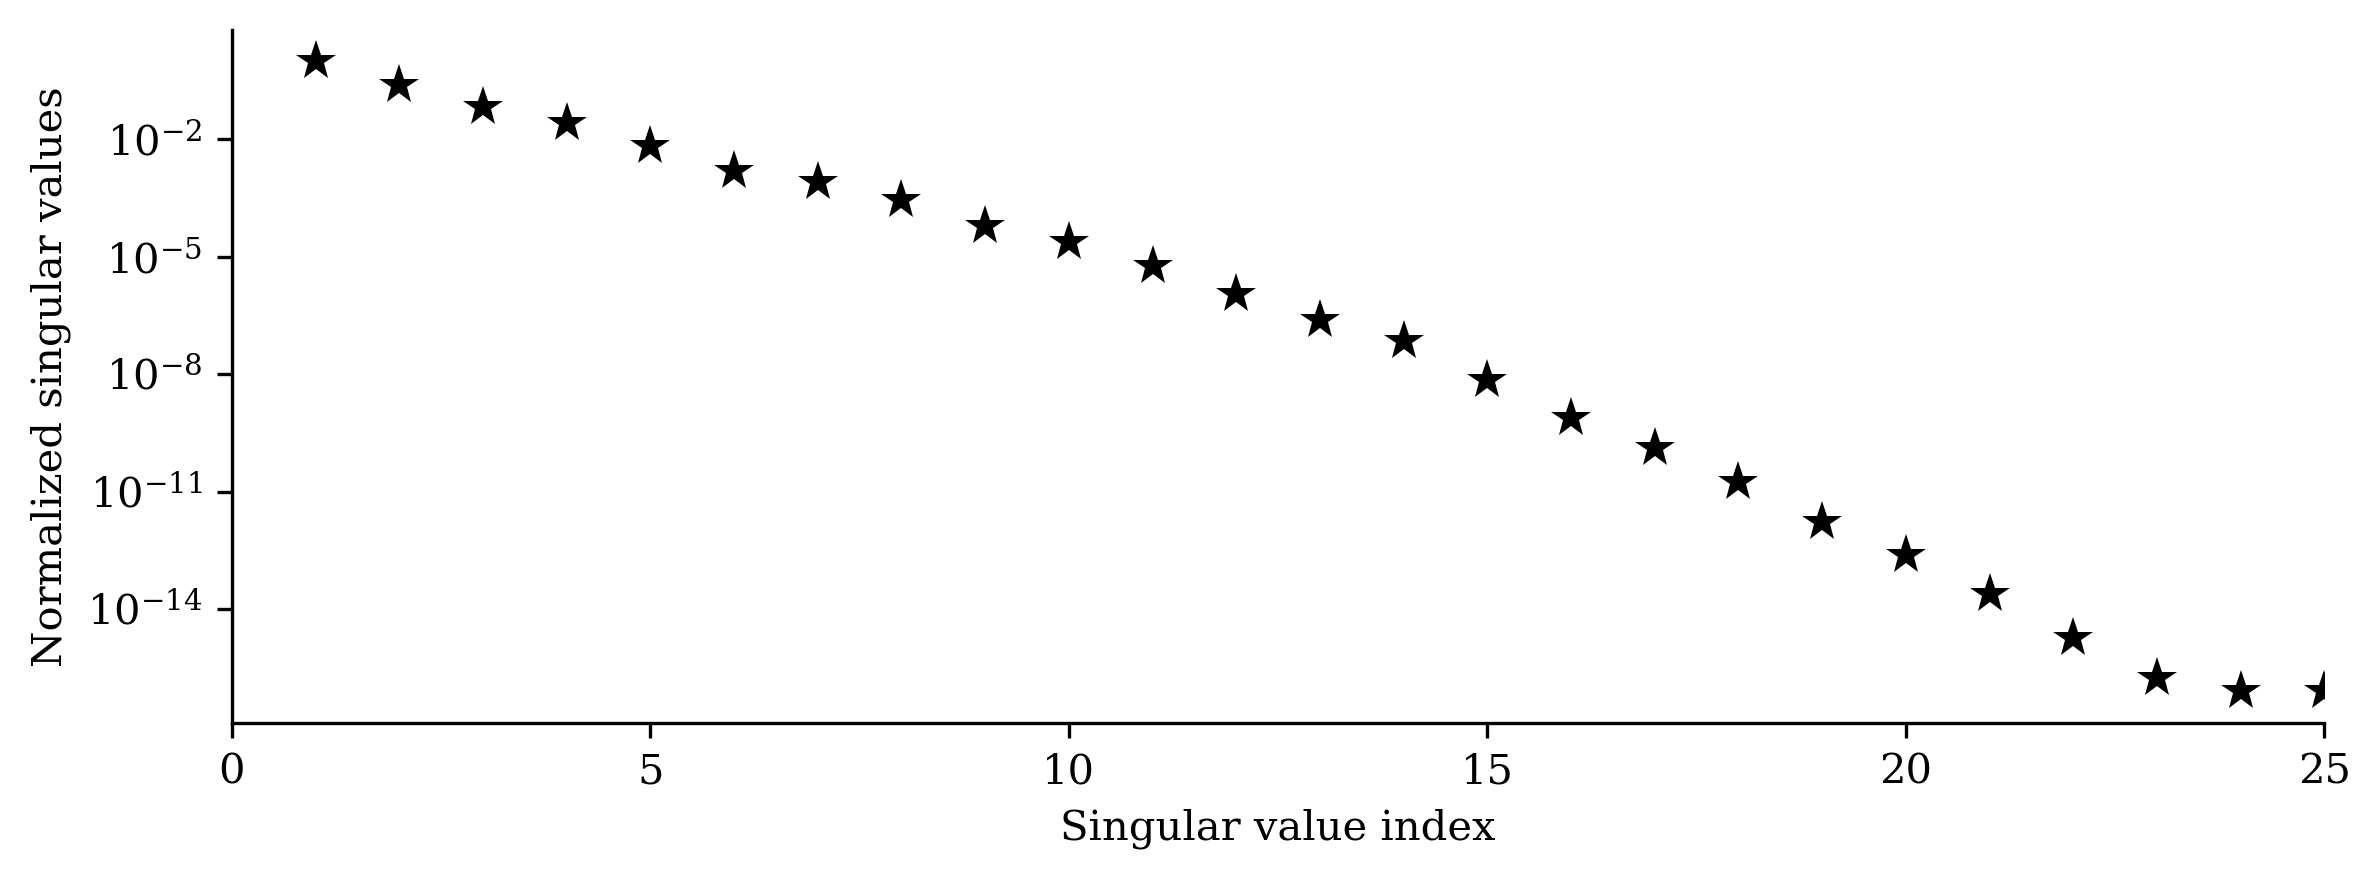

In [46]:
# Compute the POD basis, using the residual energy decay to select r.
basis = opinf.pre.PODBasis().fit(Q, residual_energy=1e-8)
print(basis)

# Check the decay of the singular values.
basis.plot_svdval_decay()
plt.xlim(0, 25)

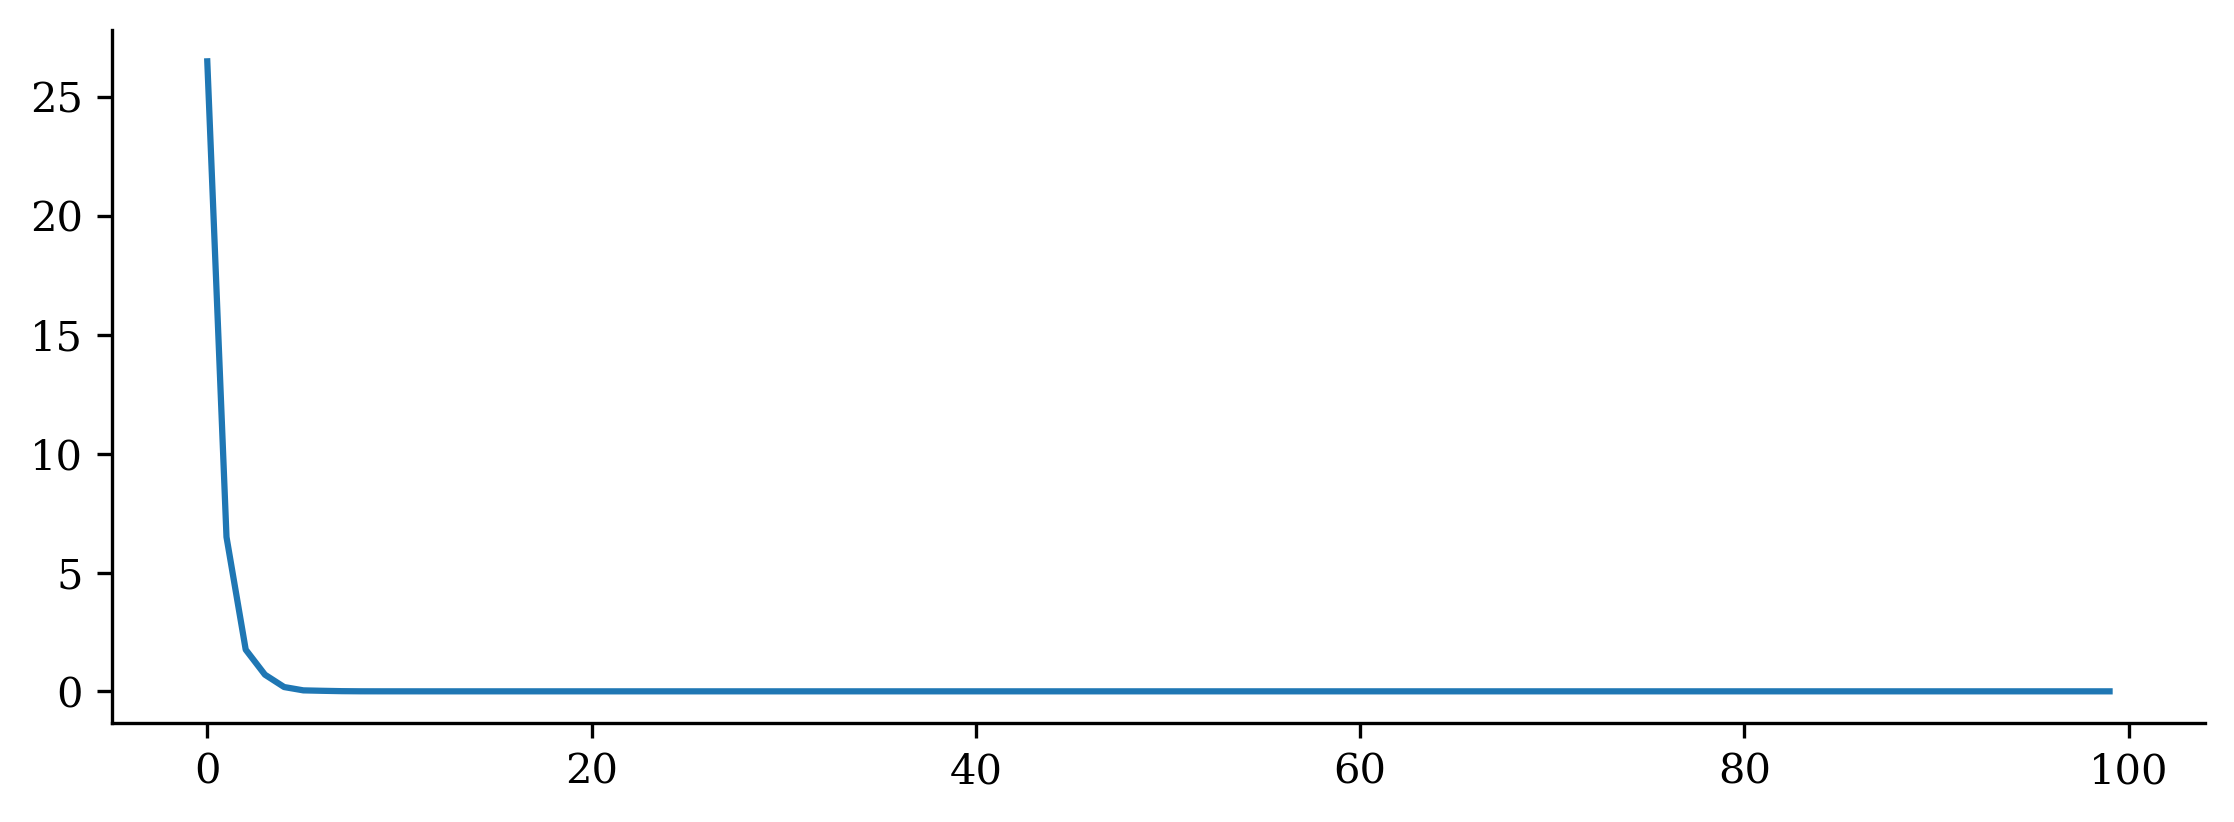

In [48]:
plt.plot(basis.svdvals)

In [49]:
rom = opinf.ContinuousOpInfROM(modelform="A")

In [50]:
rom.fit(basis=basis, states=Q_train, ddts=Qdot_train)

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 127
Reduced-order dimension r = 8

In [51]:
# Express the initial condition in the coordinates of the basis.
q0_ = basis.encode(q0)

# Solve the reduced-order model using Implicit Euler.
Q_ROM = basis.decode(implicit_euler(t, q0_, rom.A_.entries))

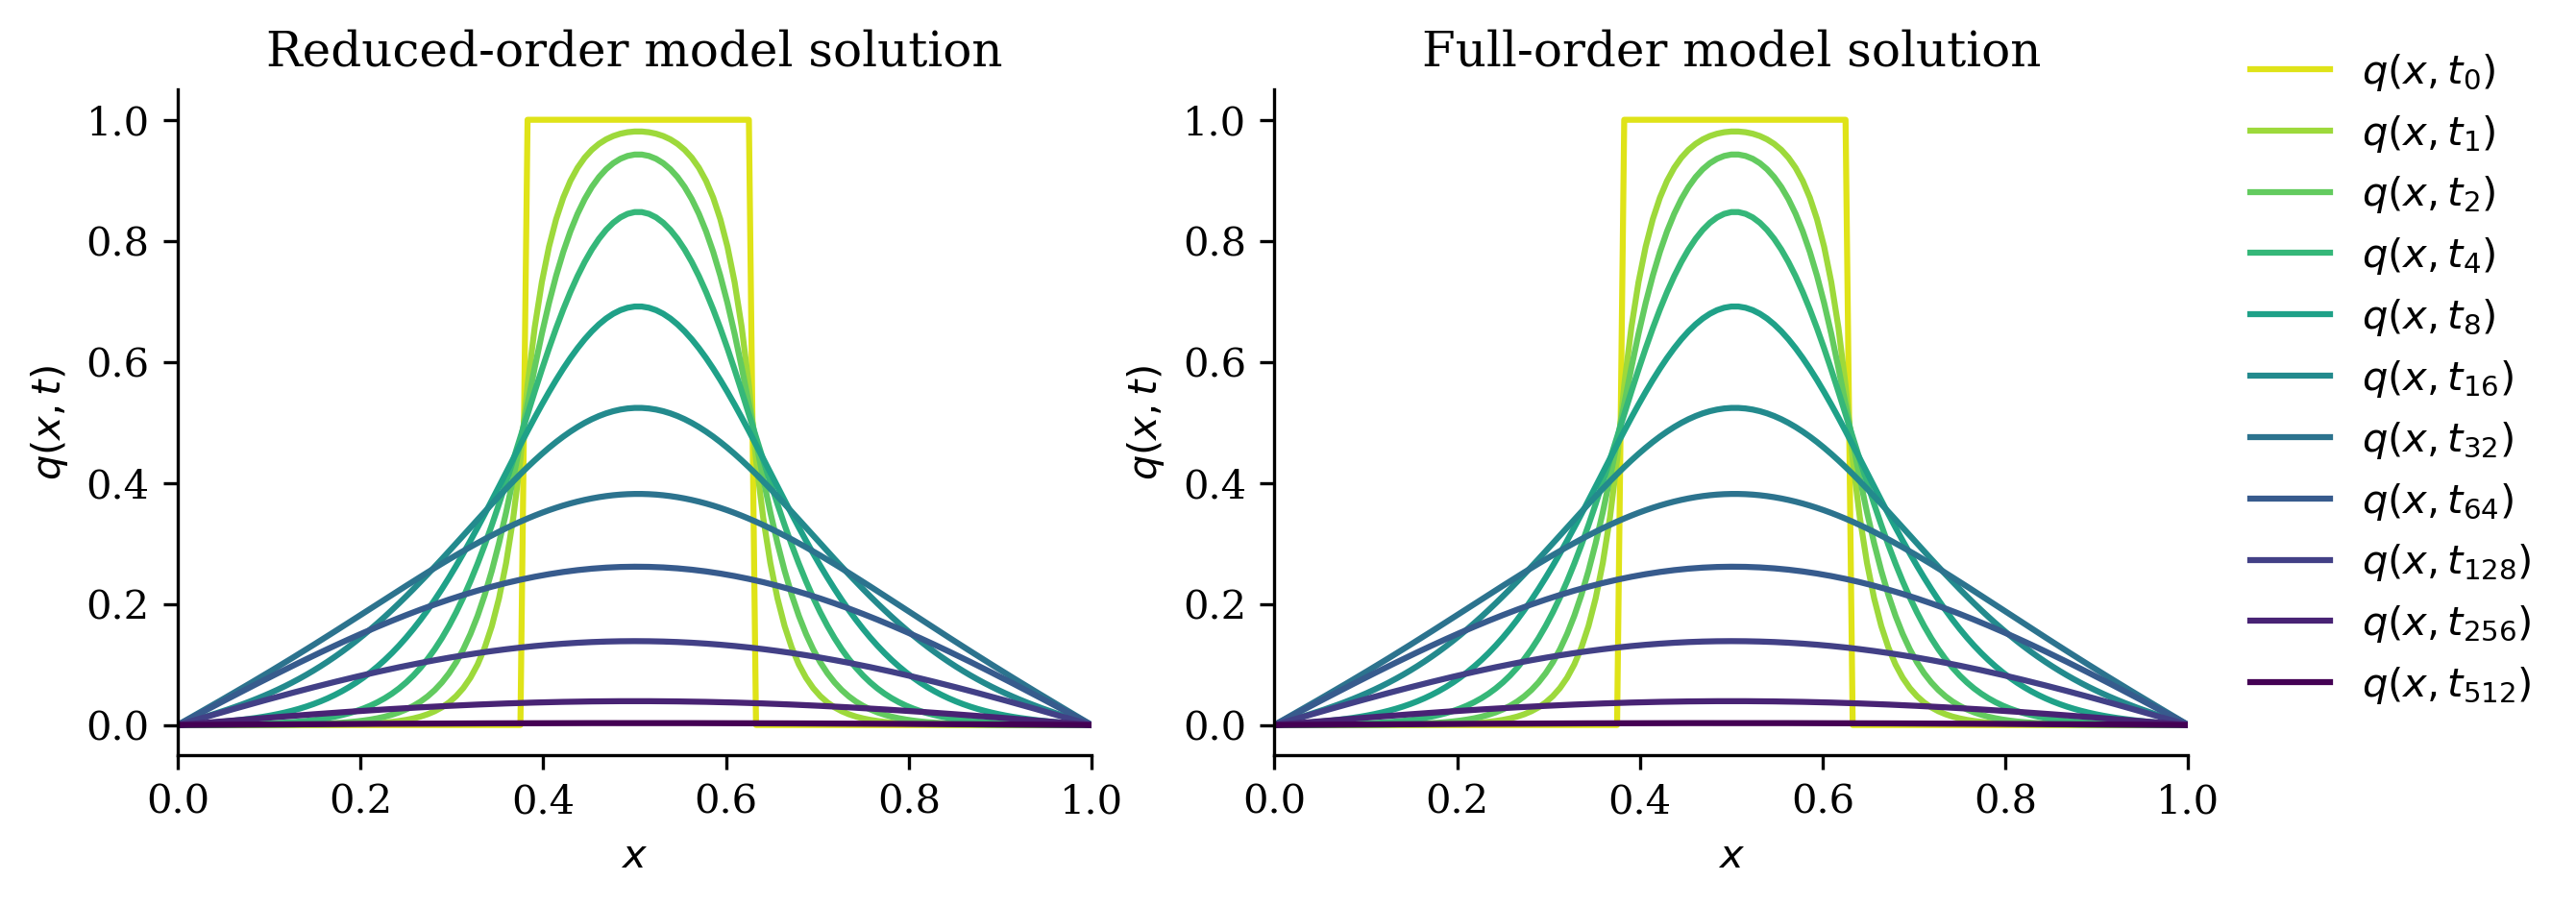

In [52]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q_ROM, "Reduced-order model solution", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()